In [2]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch import optim as optim
import matplotlib.pyplot as plt


In [3]:
# Training Set Parameters
conditions = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
num_trials_per_cond = 400
num_trials = num_trials_per_cond * 8
time_steps = 20
input_size = 3

In [4]:
# making training dataset
X = np.zeros((num_trials, time_steps, input_size), dtype=np.float32)

y_easy_c1 = np.zeros(num_trials, dtype=np.int64)
y_easy_c2 = np.zeros(num_trials, dtype=np.int64)
y_easy_c3 = np.zeros(num_trials, dtype=np.int64)

y_med_c12 = np.zeros(num_trials, dtype=np.int64)
y_med_c13 = np.zeros(num_trials, dtype=np.int64)
y_med_c23 = np.zeros(num_trials, dtype=np.int64)







trial_idx = 0
for condition in conditions:
    c1, c2, c3 = condition
    for _ in range(num_trials_per_cond):
        delay1 = random.randint(0, 9)
        delay2 = random.randint(0, 9)
        delay3 = random.randint(0, 9)
        for step in range(time_steps):
            X[trial_idx][step][0] = 0 if delay1 >= step else bernoulli.rvs(c1)
            X[trial_idx][step][1] = 0 if delay2 >= step else bernoulli.rvs(c2)
            X[trial_idx][step][2] = 0 if delay3 >= step else bernoulli.rvs(c3)
        y_easy_c1[trial_idx] = c1
        y_easy_c2[trial_idx] = c2
        y_easy_c3[trial_idx] = c3
        
        y_med_c12[trial_idx] = c1 ^ c2 
        y_med_c13[trial_idx] = c1 ^ c3
        y_med_c23[trial_idx] = c2 ^ c3

        trial_idx += 1



    

In [5]:
# testing set params
# all lambda values are high lambda values, as input to the bernoulli function is high
easy_lambda = 0.65
medium_lambda = 0.7
hard_lambda = 0.77

conditions = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
num_trials_per_cond = 40
num_trials = num_trials_per_cond * 8
time_steps = 20
input_size = 3

In [6]:
# making test set for easy task

# Initialize arrays for test inputs and targets
X_test_easy = np.zeros((num_trials, time_steps, input_size), dtype=np.float32)
y_easy_c1_test = np.zeros(num_trials, dtype=np.int64)
y_easy_c2_test = np.zeros(num_trials, dtype=np.int64)
y_easy_c3_test = np.zeros(num_trials, dtype=np.int64)

trial_idx = 0
for condition in conditions:
    cond1, cond2, cond3 = condition
    c1 = easy_lambda if cond1 == 1 else 1- easy_lambda
    c2 = easy_lambda if cond2 == 1 else 1- easy_lambda
    c3 = easy_lambda if cond3 == 1 else 1- easy_lambda
    for _ in range(num_trials_per_cond):
        delay1 = random.randint(0, 9)
        delay2 = random.randint(0, 9)
        delay3 = random.randint(0, 9)
        for step in range(time_steps):
            X_test_easy[trial_idx][step][0] = 0 if delay1 >= step else bernoulli.rvs(c1)
            X_test_easy[trial_idx][step][1] = 0 if delay2 >= step else bernoulli.rvs(c2)
            X_test_easy[trial_idx][step][2] = 0 if delay3 >= step else bernoulli.rvs(c3)

        y_easy_c1_test[trial_idx] = cond1
        y_easy_c2_test[trial_idx] = cond2   
        y_easy_c3_test[trial_idx] = cond3
        
        trial_idx += 1

In [7]:
# making test set for medium task

# Initialize arrays for test inputs and targets
X_test_easy = np.zeros((num_trials, time_steps, input_size), dtype=np.float32)
y_med_c12 = np.zeros(num_trials, dtype=np.int64)
y_med_c13 = np.zeros(num_trials, dtype=np.int64)
y_med_c23 = np.zeros(num_trials, dtype=np.int64)

trial_idx = 0
for condition in conditions:
    cond1, cond2, cond3 = condition
    c1 = medium_lambda if cond1 == 1 else 1- medium_lambda
    c2 = medium_lambda if cond2 == 1 else 1- medium_lambda
    c3 = medium_lambda if cond3 == 1 else 1- medium_lambda

    for _ in range(num_trials_per_cond):
        delay1 = random.randint(0, 9)
        delay2 = random.randint(0, 9)
        delay3 = random.randint(0, 9)
        for step in range(time_steps):
            X_test_easy[trial_idx][step][0] = 0 if delay1 >= step else bernoulli.rvs(c1)
            X_test_easy[trial_idx][step][1] = 0 if delay2 >= step else bernoulli.rvs(c2)
            X_test_easy[trial_idx][step][2] = 0 if delay3 >= step else bernoulli.rvs(c3)

        y_med_c12[trial_idx] = cond1 ^ cond2
        y_med_c13[trial_idx] = cond1 ^ cond3        
        y_med_c23[trial_idx] = cond2 ^ cond3



        trial_idx += 1

In [8]:
# Random unitary transformation
input_dim = X.shape[-1]  # Get the input dimension
random_rotation = np.random.randn(input_dim, input_dim)
q, r = np.linalg.qr(random_rotation)
random_rotation = q  # q is a unitary matrix

# Apply the same random rotation to both X and X_test
X = np.einsum('ijk,kl->ijl', X, random_rotation)
X_test_easy = np.einsum('ijk,kl->ijl', X_test_easy, random_rotation)

In [9]:
class WhiskerDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_easy_c1_tensor = torch.tensor(y_easy_c1, dtype=torch.long)
y_easy_c2_tensor = torch.tensor(y_easy_c2, dtype=torch.long)
y_easy_c3_tensor = torch.tensor(y_easy_c3, dtype=torch.long)


# Convert to PyTorch tensors
X_test_easy_tensor = torch.tensor(X_test_easy, dtype=torch.float32)
y_easy_c1_test_tensor = torch.tensor(y_easy_c1_test, dtype=torch.long)
y_easy_c2_test_tensor = torch.tensor(y_easy_c2_test, dtype=torch.long)
y_easy_c3_test_tensor = torch.tensor(y_easy_c3_test, dtype=torch.long)
    


In [11]:
def split_dataset(X, y, test_size=0.2, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

In [12]:

X_train_c1, X_val_c1, y_train_c1, y_val_c1 = split_dataset(X_tensor, y_easy_c1_tensor)
X_train_c2, X_val_c2, y_train_c2, y_val_c2 = split_dataset(X_tensor, y_easy_c2_tensor)
X_train_c3, X_val_c3, y_train_c3, y_val_c3 = split_dataset(X_tensor, y_easy_c3_tensor)

# Create Dataset and DataLoader for each split
train_dataset_c1 = WhiskerDataset(X_train_c1, y_train_c1)
val_dataset_c1 = WhiskerDataset(X_val_c1, y_val_c1)

train_dataset_c2 = WhiskerDataset(X_train_c2, y_train_c2)
val_dataset_c2 = WhiskerDataset(X_val_c2, y_val_c2)

train_dataset_c3 = WhiskerDataset(X_train_c3, y_train_c3)
val_dataset_c3 = WhiskerDataset(X_val_c3, y_val_c3)

train_dataloader_c1 = DataLoader(train_dataset_c1, batch_size=20, shuffle=True)
val_dataloader_c1 = DataLoader(val_dataset_c1, batch_size=20, shuffle=False)

train_dataloader_c2 = DataLoader(train_dataset_c2, batch_size=20, shuffle=True)
val_dataloader_c2 = DataLoader(val_dataset_c2, batch_size=20, shuffle=False)

train_dataloader_c3 = DataLoader(train_dataset_c3, batch_size=20, shuffle=True)
val_dataloader_c3 = DataLoader(val_dataset_c3, batch_size=20, shuffle=False)


# Create test Dataset and DataLoader
test_dataset_c1 = WhiskerDataset(X_test_easy_tensor, y_easy_c1_test_tensor)
test_dataloader_c1 = DataLoader(test_dataset_c1, batch_size=20, shuffle=False)

test_dataset_c2 = WhiskerDataset(X_test_easy_tensor, y_easy_c2_test_tensor)
test_dataloader_c2 = DataLoader(test_dataset_c2, batch_size=20, shuffle=False)

test_dataset_c3 = WhiskerDataset(X_test_easy_tensor, y_easy_c3_test_tensor)
test_dataloader_c3 = DataLoader(test_dataset_c3, batch_size=20, shuffle=False)


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparams

input_size = 3
sequence_len = 20
num_layers = 1
hidden_size = 60
num_classes = 2
batch_size = 20
num_epochs = 2 # variables num epochs
learning_rate = 0.005
weight_decay = 10 ** -10 # l2 regularization term
max_epochs_easy = 20
max_epochs_medium = 40
max_epochs_hard = 100

In [14]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_len):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_len = sequence_len
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        noise = torch.randn_like(out) # strength of noise is always 1
        out += noise
        out = F.relu(out)

        

        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out



In [15]:
model1 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)
model2 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)
model3 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)

loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
loss_fn3 = nn.CrossEntropyLoss()

optim1 = optim.Adam(params=model1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optim2 = optim.Adam(params=model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optim3 = optim.Adam(params=model3.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch [1/20], Train Loss: 0.2606, Val Loss: 0.0077, Val Accuracy: 100.00%
Test Accuracy: 75.62%
Epoch [2/20], Train Loss: 0.0044, Val Loss: 0.0024, Val Accuracy: 100.00%
Test Accuracy: 74.38%
Epoch [3/20], Train Loss: 0.0020, Val Loss: 0.0016, Val Accuracy: 100.00%
Test Accuracy: 73.75%
Epoch [4/20], Train Loss: 0.1785, Val Loss: 0.9843, Val Accuracy: 54.69%
Test Accuracy: 49.38%
Epoch [5/20], Train Loss: 0.8121, Val Loss: 0.5325, Val Accuracy: 82.19%
Test Accuracy: 71.88%
Epoch [6/20], Train Loss: 0.5207, Val Loss: 0.3206, Val Accuracy: 92.03%
Test Accuracy: 82.19%
Epoch [7/20], Train Loss: 0.1489, Val Loss: 0.0631, Val Accuracy: 99.38%
Test Accuracy: 70.00%
Epoch [8/20], Train Loss: 0.0549, Val Loss: 0.0421, Val Accuracy: 99.69%
Test Accuracy: 70.00%
Epoch [9/20], Train Loss: 0.0423, Val Loss: 0.0329, Val Accuracy: 99.69%
Test Accuracy: 67.19%
Epoch [10/20], Train Loss: 0.0301, Val Loss: 0.0301, Val Accuracy: 99.84%
Test Accuracy: 68.44%
Epoch [11/20], Train Loss: 0.0292, Val Loss: 0

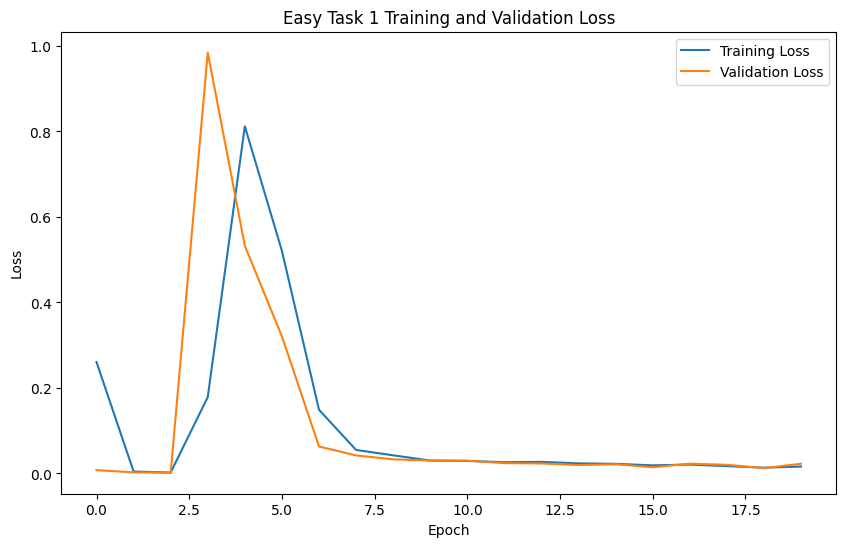

Epoch [1/20], Train Loss: 0.1103, Val Loss: 0.0033, Val Accuracy: 100.00%
Test Accuracy: 78.44%
Epoch [2/20], Train Loss: 0.0022, Val Loss: 0.0015, Val Accuracy: 100.00%
Test Accuracy: 74.06%
Epoch [3/20], Train Loss: 0.0011, Val Loss: 0.0008, Val Accuracy: 100.00%
Test Accuracy: 74.38%
Epoch [4/20], Train Loss: 0.0007, Val Loss: 0.0006, Val Accuracy: 100.00%
Test Accuracy: 74.06%
Target loss of 0.001 reached at epoch 4


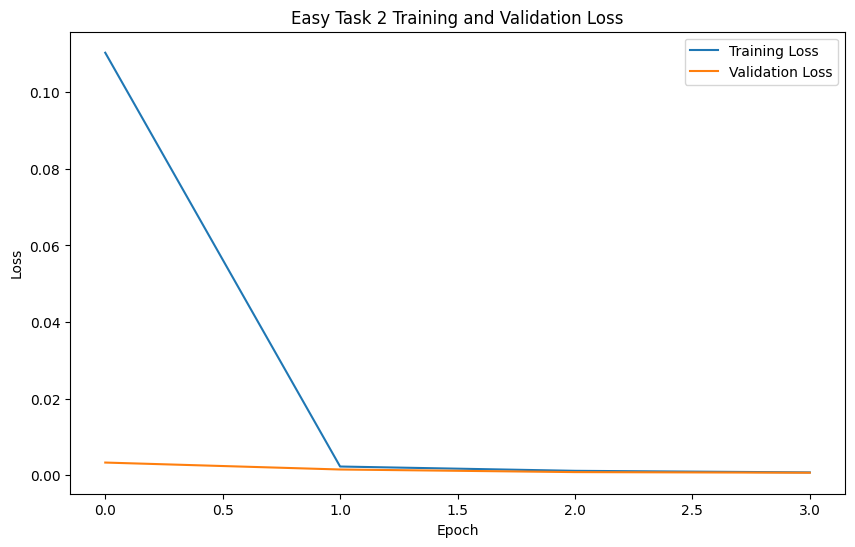

Epoch [1/20], Train Loss: 0.1398, Val Loss: 0.0062, Val Accuracy: 100.00%
Test Accuracy: 78.75%
Epoch [2/20], Train Loss: 0.0035, Val Loss: 0.0023, Val Accuracy: 100.00%
Test Accuracy: 80.94%
Epoch [3/20], Train Loss: 0.0014, Val Loss: 0.0012, Val Accuracy: 100.00%
Test Accuracy: 79.06%
Epoch [4/20], Train Loss: 0.0009, Val Loss: 0.0007, Val Accuracy: 100.00%
Test Accuracy: 77.50%
Target loss of 0.001 reached at epoch 4


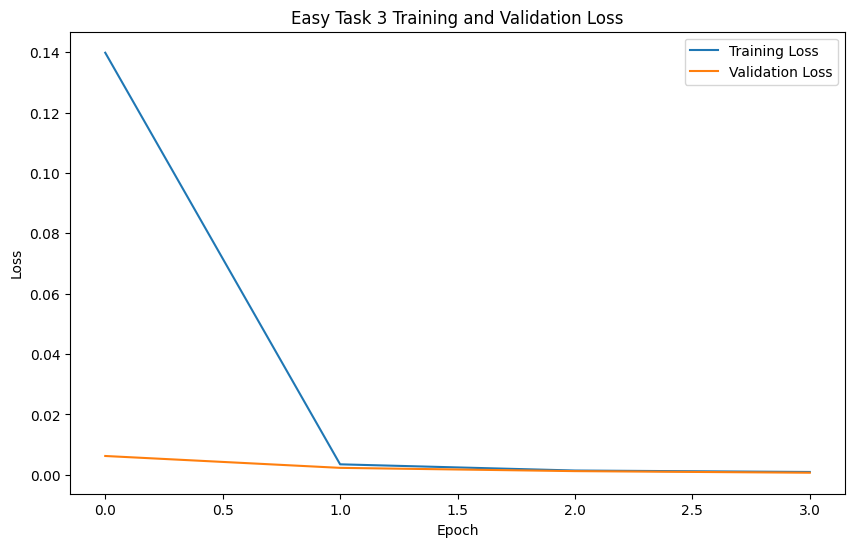

In [16]:
data_list = [
(model1, loss_fn1, optim1, "Easy Task 1", train_dataloader_c1, val_dataloader_c1, test_dataloader_c1), \
(model2, loss_fn2, optim2, "Easy Task 2", train_dataloader_c2, val_dataloader_c2, test_dataloader_c2), \
(model3, loss_fn3, optim3, "Easy Task 3", train_dataloader_c3, val_dataloader_c3, test_dataloader_c3)
]

for model, loss_fn, optimizer, task_label, train_dataloader, val_dataloader, test_dataloader in data_list:
    train_losses = []
    val_losses = []
    val_accuracies = []
    test_accuracies = []  # Initialize list for storing test accuracies

    target_loss = 1e-3
    num_epochs = max_epochs_easy  # Set the appropriate number of epochs based on the task complexity

    for epoch in range(num_epochs):
        # Training loopx
        model.train()
        train_loss = 0
        for data, target in train_dataloader:
            data = data.to(device)
            target = target.to(device)

            scores = model(data)
            loss = loss_fn(scores, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        # Calculate average training loss for the epoch
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_dataloader:
                data = data.to(device)
                target = target.to(device)

                scores = model(data)
                loss = loss_fn(scores, target)
                val_loss += loss.item()
                _, predicted = torch.max(scores.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Calculate average validation loss and accuracy for the epoch
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
        
        # Test loop (for test accuracy)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_dataloader:  # Using the test dataloader
                data = data.to(device)
                target = target.to(device)

                scores = model(data)
                _, predicted = torch.max(scores.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Calculate test accuracy
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        
        # Check for early stopping
        if train_loss <= target_loss:
            print(f"Target loss of {target_loss} reached at epoch {epoch+1}")
            break


    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(task_label + ' Training and Validation Loss')
    plt.legend()
    plt.show()
